## N-gram language model

### Training Process
1.	preprocess_text: Preprocesses the text by splitting it into individual lowercase words.
2.	Update Vocabulary: Expands the vocabulary with newly encountered words.
3.	add_sentence_markers: Adds start and end markers to each sentence.
4.	get_ngrams and get_contexts: Extracts N-grams and their corresponding contexts (essentially the N-gram minus the last word).

### Generation Process
1.	Calculate the probabilities of all N-grams that match the given context.
2.	Select the word with the highest probability as the next predicted word.

### Additional Notes

Since N-grams follow the Markov process, the probability of an entire sentence can be computed. Based on this, the model’s perplexity can also be calculated to evaluate its performance.


In [72]:
import re
import math
from collections import defaultdict, Counter
from typing import List, Tuple, Dict
import logging
import time
import random
import os

class NGramModel:
    def __init__(self, n: int = 2):
        self.n = n
        self.ngram_counts = defaultdict(int)  # n-gram計數
        self.context_counts = defaultdict(int)  # (n-1)-gram計數
        self.vocabulary = set()  # 詞彙表
        self.total_words = 0
        
        self.start_token = "<s>"
        self.end_token = "</s>"
        self.unk_token = "<unk>"
    
    def preprocess_text(self, text: str) -> List[str]:
        text = text.lower()
        words = re.findall(r'\b\w+\b|[.!?]', text)
        return words
    
    def add_sentence_markers(self, words: List[str]) -> List[str]:
        start_markers = [self.start_token] * (self.n - 1)
        return start_markers + words + [self.end_token]
    
    def get_ngrams(self, words: List[str]) -> List[Tuple[str, ...]]:
        ngrams = []
        for i in range(len(words) - self.n + 1):
            ngram = tuple(words[i:i + self.n])
            ngrams.append(ngram)
        return ngrams
    
    def get_contexts(self, words: List[str]) -> List[Tuple[str, ...]]:
        contexts = []
        for i in range(len(words) - self.n + 1):
            context = tuple(words[i:i + self.n - 1])
            contexts.append(context)
        return contexts
    
    def train(self, train_file: str):
        print(f"Start training {self.n}-gram model...")
        
        line_count = 0
        with open(train_file, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                
                words = self.preprocess_text(line)
                if len(words) == 0:
                    continue

                self.vocabulary.update(words)
                self.total_words += len(words)
                
                words_with_markers = self.add_sentence_markers(words)
                
                ngrams = self.get_ngrams(words_with_markers)
                contexts = self.get_contexts(words_with_markers)
                
                for ngram in ngrams:
                    self.ngram_counts[ngram] += 1
                
                for context in contexts:
                    self.context_counts[context] += 1

        print(f"Training completed!")
        print(f"Total words: {self.total_words}")
        print(f"Vocabulary size: {len(self.vocabulary)}")
        print(f"N-gram total: {len(self.ngram_counts)}")
        print(f"Context total: {len(self.context_counts)}")

    def get_probability(self, ngram: Tuple[str, ...]) -> float:
        if len(ngram) != self.n:
            raise ValueError(f"N-gram長度應為 {self.n}")
        
        context = ngram[:-1]
        
        if self.context_counts[context] == 0:
            return 1e-10 
        
        return self.ngram_counts[ngram] / self.context_counts[context]
    
    def get_sentence_probability(self, sentence: str) -> float:
        words = self.preprocess_text(sentence)
        if len(words) == 0:
            return float('-inf')
        
        words_with_markers = self.add_sentence_markers(words)
        ngrams = self.get_ngrams(words_with_markers)
        
        log_prob = 0.0
        for ngram in ngrams:
            prob = self.get_probability(ngram)
            if prob > 0:
                log_prob += math.log(prob)
            else:
                log_prob += math.log(1e-10)
        
        return log_prob
    
    def calculate_perplexity(self, test_file: str) -> float:
        print(f"Calculating {self.n}-gram model perplexity...")
        
        total_log_prob = 0.0
        total_words = 0
        
        with open(test_file, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                
                words = self.preprocess_text(line)
                if len(words) == 0:
                    continue
                
                log_prob = self.get_sentence_probability(line)
                total_log_prob += log_prob
                total_words += len(words)
                
        avg_log_prob = total_log_prob / total_words
        perplexity = math.exp(-avg_log_prob)
        
        print(f"測試集總詞數: {total_words}")
        print(f"平均對數概率: {avg_log_prob:.6f}")
        print(f"{self.n}-gram 困惑度: {perplexity:.2f}")
        
        return perplexity
    
    def calculate_accuracy(self, test_file: str) -> float:
        print(f"Calculating {self.n}-gram model accuracy...")
        
        correct_predictions = 0
        total_predictions = 0
        
        with open(test_file, 'r', encoding='utf-8') as f:
            count = 0
            for line in f:
                line = line.strip()
                if not line:
                    continue
                
                words = self.preprocess_text(line)
                if len(words) < self.n:
                    continue
                
                words_with_markers = self.add_sentence_markers(words)
                
                for i in range(self.n - 1, len(words_with_markers)):
                    count += 1
                    if count > 10000:
                        break

                    context = tuple(words_with_markers[i - self.n + 1:i])

                    actual_word = words_with_markers[i]

                    predicted_word = self.predict_next_word(context)
                    
                    if predicted_word == actual_word:
                        correct_predictions += 1
                    total_predictions += 1
                
        accuracy = correct_predictions / total_predictions
        
        print(f"正確預測數: {correct_predictions}")
        print(f"總預測數: {total_predictions}")
        print(f"{self.n}-gram 準確率: {accuracy:.4f} ({accuracy*100:.2f}%)")
        
        return accuracy
    
    def predict_next_word(self, context: Tuple[str, ...]) -> str:
        if len(context) != self.n - 1:
            raise ValueError(f"Context 長度應為 {self.n - 1}")
        
        candidate_ngrams = []
        for ngram in self.ngram_counts:
            if ngram[:-1] == context:
                probability = self.get_probability(ngram)
                candidate_ngrams.append((ngram[-1], probability))
        
        if not candidate_ngrams:
            return self.unk_token
        
        best_word = max(candidate_ngrams, key=lambda x: x[1])[0]
        return best_word
    
    def generate_text(self, context: Tuple[str, ...], max_length: int = 20) -> str:

        if len(context) != self.n - 1:
            raise ValueError(f"Context長度應為 {self.n - 1}")
        
        result = list(context)
        current_context = context
        
        for _ in range(max_length):
            candidates = []
            for ngram, count in self.ngram_counts.items():
                if ngram[:-1] == current_context:
                    candidates.extend([ngram[-1]] * count)

            if not candidates:
                break 
            
            candidates = [word for word in candidates if word != self.end_token]

            next_word = random.choice(candidates)
            
            result.append(next_word)
            current_context = tuple(result[-(self.n-1):])
        
        filtered_result = [word for word in result if word != self.start_token]
        return ' '.join(filtered_result)

## N-gram training

In [ ]:
train_file = "data/train.txt"
test_file = "data/test.txt"

print("=" * 60)
print("N-gram model Training and Evaluation")
print("=" * 60)

results = {}
trained_models = {}  # Store trained models for text generation

for n in [2, 3]:
    print(f"\n{'='*20} N={n} ({'Bigram' if n==2 else 'Trigram'}) {'='*20}")
    
    start_time = time.time()

    model = NGramModel(n=n)

    print(f"Train {n}-gram model...")
    model.train(train_file)
    
    training_time = time.time() - start_time
    print(f"Training time: {training_time:.2f} seconds")

    # Calculate perplexity and accuracy
    start_time = time.time()
    perplexity = model.calculate_perplexity(test_file)
    accuracy = model.calculate_accuracy(test_file)
    test_time = time.time() - start_time

    print(f"Testing time: {test_time:.2f} seconds")
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    # save results and model
    results[n] = {
        'perplexity': perplexity,
        'accuracy': accuracy,
        'training_time': training_time,
        'test_time': test_time,
        'vocab_size': len(model.vocabulary),
        'total_words': model.total_words,
        'ngram_types': len(model.ngram_counts),
        'context_types': len(model.context_counts)
    }
    trained_models[n] = model  # Store the trained model

    print(f"\n{n}-gram model text generation examples:")
    try:
        if n == 2:
            contexts = [("add",), ("cook",), ("bake",)]
        else:
            contexts = [("add", "the"), ("cook", "for"), ("bake", "at")]
        
        for context in contexts:
            generated = model.generate_text(context, max_length=15)
            print(f"  Context: {' '.join(context)} -> {generated}")
    except Exception as e:
        print(f"  Error occurred during text generation: {e}")

# Results comparison
print("\n" + "=" * 60)
print("Results Comparison")
print("=" * 60)

print(f"{'Metric':<20} {'Bigram (n=2)':<15} {'Trigram (n=3)':<15} {'Difference':<15}")
print("-" * 65)

bigram_pp = results[2]['perplexity']
trigram_pp = results[3]['perplexity']
pp_diff = ((trigram_pp - bigram_pp) / bigram_pp) * 100

print(f"{'Perplexity':<20} {bigram_pp:<15.2f} {trigram_pp:<15.2f} {pp_diff:+.2f}%")

bigram_acc = results[2]['accuracy']
trigram_acc = results[3]['accuracy']
acc_diff = ((trigram_acc - bigram_acc) / bigram_acc) * 100

print(f"{'Accuracy':<20} {bigram_acc:<15.4f} {trigram_acc:<15.4f} {acc_diff:+.2f}%")

bigram_time = results[2]['training_time']
trigram_time = results[3]['training_time']
time_diff = ((trigram_time - bigram_time) / bigram_time) * 100

print(f"{'Training time':<20} {bigram_time:<15.2f} {trigram_time:<15.2f} {time_diff:+.2f}%")

bigram_ngrams = results[2]['ngram_types']  
trigram_ngrams = results[3]['ngram_types']
ngram_diff = ((trigram_ngrams - bigram_ngrams) / bigram_ngrams) * 100

print(f"{'N-gram types':<20} {bigram_ngrams:<15,} {trigram_ngrams:<15,} {ngram_diff:+.2f}%")

print(f"{'Vocabulary size':<20} {results[2]['vocab_size']:<15,} {results[3]['vocab_size']:<15,} {'Same':<15}")
print(f"{'Total words':<20} {results[2]['total_words']:<15,} {results[3]['total_words']:<15,} {'Same':<15}")

N-gram model Training and Evaluation

==================== N=2 (Bigram) ====================
Train 2-gram model...
Start training 2-gram model...
Training completed!
Total words: 17728510
Vocabulary size: 38404
N-gram total: 660108
Context total: 38405
Training time: 12.00 seconds
Calculating 2-gram model perplexity...
測試集總詞數: 4420449
平均對數概率: -4.562487
2-gram 困惑度: 95.82
Calculating 2-gram model accuracy...
正確預測數: 2707
總預測數: 10000
2-gram 準確率: 0.2707 (27.07%)
Testing time: 313.57 seconds
Accuracy: 0.2707 (27.07%)

2-gram model text generation examples:
  Context: add -> add very hot chocolate begins to pan and carrots are traditionally served warm it is just
  Context: cook -> cook until lightly greased 13x9 pan with salt and french bread pulls away from under cold
  Context: bake -> bake for the skin is best flavour of the bread crumb mixture into chops are not

==================== N=3 (Trigram) ====================
Train 3-gram model...
Start training 3-gram model...
Training complete

### Question: Use n= 2 and n= 3 to calculate bigrams and trigrams, respectively, and evaluatethe test accuracy in test.txt and make some discussion.
Based on the results, the trigram model demonstrates better predictive performance than the bigram model. However, it also shows a higher perplexity. This can be explained by the fact that the trigram model contains a greater variety of N-gram types, resulting in lower individual N-gram probabilities and thus a lower overall sentence probability, which in turn increases the perplexity.

### Question: Please observe the hardware usage in your computer while the models are running and make some discussion.

The 2-gram model consumed approximately 1.0% of memory during training, while the 3-gram model required about 5.7%. This increase in memory usage can be attributed to the substantially larger number of unique N-gram combinations present in the 3-gram model.

## Complete the incomplete.txt

In [28]:
# Test with incomplete.txt for text completion
with open("data/incomplete.txt", "r", encoding="utf-8") as f:
    incomplete_lines = [line.strip() for line in f if line.strip()]

for i, incomplete_text in enumerate(incomplete_lines):
    words = model.preprocess_text(incomplete_text)
    context = (words[-2], words[-1])
    # Generate completion
    completion = model.generate_text(context, max_length=20)
    # Remove the context words from completion to show only new words
    context_str = ' '.join(context)
    new_words = completion[len(context_str):].strip()    
    full_completion = incomplete_text + " " + new_words
    print(f"  '{incomplete_text}' -> '{full_completion}'")

  'cover with' -> 'cover with aluminum foil and continue to set them on the pot to high and are ready to serve this with frozen'
  'roll up' -> 'roll up a day ahead and kept chilled in an 8x11 inch baking pan with cooking spray in an oven tray brushed'
  'cook the' -> 'cook the spinach mixture over dough rectangles with cheese and mint along the edge of the pan so nothing gets cold !'
  'stir in' -> 'stir in creamed mixture just enough to handle the dough from greased slotted spoon to scrape out the insides into a greased'
  'spread out' -> 'spread out on flat ends on kitchen paper and butter until creamy and soft scrambled eggs into the center comes out clean'
  'transfer the' -> 'transfer the pan with parchment paper or in a smaller bowl combine flour with a fork slightly puncture the peppers to a'
  'put the' -> 'put the cheese melts and sugar on the rim of the ricotta mix on high until sugar is dissolved and the onions'
  'push the' -> 'push the batter will be thick enough to maint

# RNN and LSTM model

In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import re
from collections import Counter, defaultdict
import time
from typing import List, Tuple, Dict
import os
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

## Vocabulary

In [87]:
class Vocabulary:
    
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.word_count = Counter()
        
        # 特殊標記
        self.pad_token = '<PAD>'
        self.unk_token = '<UNK>'
        self.start_token = '<START>'
        self.end_token = '<END>'
        
        # 初始化特殊標記
        self.add_word(self.pad_token)
        self.add_word(self.unk_token)
        self.add_word(self.start_token)
        self.add_word(self.end_token)
        
    def add_word(self, word: str) -> int:
        """添加詞彙到詞彙表"""
        if word not in self.word2idx:
            idx = len(self.word2idx)
            self.word2idx[word] = idx
            self.idx2word[idx] = word
        self.word_count[word] += 1
        return self.word2idx[word]
    
    def build_vocab(self, texts: List[str], min_freq: int = 2):
        """建立詞彙表"""
        print("Building vocabulary...")
        
        # 統計詞頻
        for text in texts:
            words = self.preprocess_text(text)
            for word in words:
                self.word_count[word] += 1
        
        # 添加高頻詞到詞彙表
        for word, count in self.word_count.items():
            if count >= min_freq and word not in self.word2idx:
                self.add_word(word)
        
        print(f"Vocabulary size: {len(self.word2idx)}")
        print(f"Most common words: {self.word_count.most_common(10)}")
    
    def preprocess_text(self, text: str) -> List[str]:
        """文本預處理"""
        text = text.lower().strip()
        words = re.findall(r'\b\w+\b', text)
        return words
    
    def text_to_indices(self, text: str) -> List[int]:
        words = self.preprocess_text(text)
        indices = [self.word2idx[self.start_token]]
        
        for word in words:
            if word in self.word2idx:
                indices.append(self.word2idx[word])
            else:
                indices.append(self.word2idx[self.unk_token])
        
        indices.append(self.word2idx[self.end_token])
        return indices
    
    def indices_to_text(self, indices: List[int]) -> str:
        words = []
        for idx in indices:
            if idx in self.idx2word:
                word = self.idx2word[idx]
                if word not in [self.pad_token, self.start_token, self.end_token]:
                    words.append(word)
        return ' '.join(words)
    
    def __len__(self):
        return len(self.word2idx)

## TextDataset

In [93]:
class TextDataset(Dataset):
    """文本數據集類別"""
    
    def __init__(self, texts: List[str], vocab: Vocabulary, seq_length: int = 3):
        self.vocab = vocab
        self.seq_length = seq_length
        self.sequences = []
        
        self.prepare_sequences(texts)
    
    def prepare_sequences(self, texts: List[str]):
        """準備訓練序列"""
        print("Preparing training sequences...")
        
        for text in texts:
            indices = self.vocab.text_to_indices(text)
            
            # 如果序列太短，跳過
            if len(indices) < 2:
                continue

            # 限制總 sequence 數量
            if len(self.sequences) >= 2500000:
                break
            
            # 創建滑動窗口序列
            for i in range(len(indices) - 1):
                # 輸入序列和目標序列
                input_seq = indices[max(0, i - self.seq_length + 1):i + 1]
                target = indices[i + 1]
                
                # 填充到固定長度
                if len(input_seq) < self.seq_length:
                    padding = [self.vocab.word2idx[self.vocab.pad_token]] * (self.seq_length - len(input_seq))
                    input_seq = padding + input_seq
                
                self.sequences.append((input_seq, target))
        
        print(f"Created {len(self.sequences)} training sequences")
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        input_seq, target = self.sequences[idx]
        return torch.tensor(input_seq, dtype=torch.long), torch.tensor(target, dtype=torch.long)

## RNN LanguageModel and Trainer

### Forwarding Flow
1. [Input x (batch, seq_len)] --> [Embedding (batch, seq_len, embed_dim)]
2. --> [RNN Layer (batch, seq_len, hidden_dim)]
3. --> [Take last time step output (batch, hidden_dim)]
4. --> [Dropout]
5. --> [Linear Layer (batch, vocab_size)]
6. --> [Output: predicted next-token logits]

In [94]:
class RNNLanguageModel(nn.Module):

    def __init__(self, vocab_size: int, embed_dim: int = 128, hidden_dim: int = 128, 
                 num_layers: int = 2, dropout: float = 0.2):
        super(RNNLanguageModel, self).__init__()
        
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers, 
                         batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_dim, vocab_size)
        self.init_weights()
    
    def init_weights(self):
        init_range = 0.1
        self.embedding.weight.data.uniform_(-init_range, init_range)
        self.linear.bias.data.zero_()
        self.linear.weight.data.uniform_(-init_range, init_range)
    
    def forward(self, x, hidden=None):
        batch_size = x.size(0)
        
        embedded = self.embedding(x)  # (batch_size, seq_len, embed_dim)
        rnn_out, hidden = self.rnn(embedded, hidden)  # (batch_size, seq_len, hidden_dim)
        last_output = rnn_out[:, -1, :]  # (batch_size, hidden_dim)
        output = self.dropout(last_output)
        output = self.linear(output)  # (batch_size, vocab_size)
        return output, hidden
    
    def init_hidden(self, batch_size, device):
        return torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)

class RNNTrainer:
    
    def __init__(self, model, vocab, device, learning_rate: float = 0.001):
        self.model = model
        self.vocab = vocab
        self.device = device
        
        self.criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2idx[vocab.pad_token])
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        self.train_losses = []
        self.train_accuracies = []
        
    def train_epoch(self, dataloader):
        self.model.train()
        total_loss = 0
        total_samples = 0
        correct_predictions = 0
        
        pbar = tqdm(dataloader, desc="Training", leave=False)
        
        for batch_idx, (data, targets) in enumerate(pbar):
            data, targets = data.to(self.device), targets.to(self.device)
            batch_size = data.size(0)
            
            hidden = self.model.init_hidden(batch_size, self.device)
            
            outputs, _ = self.model(data, hidden)
            loss = self.criterion(outputs, targets)
            
            _, predicted = torch.max(outputs.data, 1)
            correct_predictions += (predicted == targets).sum().item()
            
            self.optimizer.zero_grad()
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=5.0)
            
            self.optimizer.step()
            
            total_loss += loss.item() * batch_size
            total_samples += batch_size
            
            current_loss = total_loss / total_samples
            current_acc = correct_predictions / total_samples
            pbar.set_postfix({
                'Loss': f'{current_loss:.4f}',
                'Acc': f'{current_acc:.4f}'
            })

        
        avg_loss = total_loss / total_samples
        accuracy = correct_predictions / total_samples
        
        self.train_losses.append(avg_loss)
        self.train_accuracies.append(accuracy)
        
        return avg_loss, accuracy
    
    def evaluate(self, dataloader):
        self.model.eval()
        total_loss = 0
        total_samples = 0
        correct_predictions = 0
        
        pbar = tqdm(dataloader, desc="Evaluating", leave=False)
        
        with torch.no_grad():
            for data, targets in pbar:
                data, targets = data.to(self.device), targets.to(self.device)
                batch_size = data.size(0)
                
                hidden = self.model.init_hidden(batch_size, self.device)
                outputs, _ = self.model(data, hidden)
                loss = self.criterion(outputs, targets)
                
                _, predicted = torch.max(outputs.data, 1)
                correct_predictions += (predicted == targets).sum().item()
                
                total_loss += loss.item() * batch_size
                total_samples += batch_size
                
                current_loss = total_loss / total_samples
                current_acc = correct_predictions / total_samples
                pbar.set_postfix({
                    'Loss': f'{current_loss:.4f}',
                    'Acc': f'{current_acc:.4f}'
                })
        
        avg_loss = total_loss / total_samples
        accuracy = correct_predictions / total_samples

        entropy = avg_loss / math.log(2)
        perplexity = 2 ** entropy
        
        return avg_loss, accuracy, perplexity
    
    def generate_text(self, start_text: str, max_length: int = 3, temperature: float = 1.0):
        self.model.eval()
        
        # 預處理起始文本
        indices = self.vocab.text_to_indices(start_text)
        indices = indices[:-1]

        if len(indices) == 0:
            indices = [self.vocab.word2idx[self.vocab.start_token]]
        
        generated = indices.copy()

        end_idx = self.vocab.word2idx[self.vocab.end_token]
        
        with torch.no_grad():
            for _ in range(max_length-3):
                input_seq = generated[-3:]
                if len(input_seq) < 3:
                    padding = [self.vocab.word2idx[self.vocab.pad_token]] * (3 - len(input_seq))
                    input_seq = padding + input_seq
                
                input_tensor = torch.tensor([input_seq], dtype=torch.long).to(self.device)
                hidden = self.model.init_hidden(1, self.device)

                outputs, _ = self.model(input_tensor, hidden)

                outputs[:, end_idx] = float('-inf')


                outputs = outputs / temperature
                probabilities = torch.softmax(outputs, dim=-1)
                
                next_word_idx = torch.multinomial(probabilities, 1).item()

                generated.append(next_word_idx)
        
        return self.vocab.indices_to_text(generated)
    
    def plot_learning_curves(self, save_path='rnn_learning_curves.png'):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        epochs = range(1, len(self.train_losses) + 1)
        ax1.plot(epochs, self.train_losses, 'b-', label='Training Loss')
        ax1.set_title('Training Loss Curve')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        ax2.plot(epochs, self.train_accuracies, 'r-', label='Training Accuracy')
        ax2.set_title('Training Accuracy Curve')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Learning curves saved to {save_path}")

## LSTM Language Model and Trainer

### Forwarding Flow
1. [Input x (batch, seq_len)] --> [Embedding Layer (batch, seq_len, embed_dim)]
2. --> [LSTM Layer Uses (h_t, c_t) for sequence modeling]
3. --> [Take last time step output (batch, hidden_dim)]
4. --> [Dropout]
5. --> [Linear Layer (batch, vocab_size)]
6. --> [Output: predicted next-token logits]

In [95]:
class LSTMLanguageModel(nn.Module):
    
    def __init__(self, vocab_size: int, embed_dim: int = 128, hidden_dim: int = 128, 
                 num_layers: int = 2, dropout: float = 0.2):
        super(LSTMLanguageModel, self).__init__()
        
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, 
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_dim, vocab_size)
        self.init_weights()
    
    def init_weights(self):
        init_range = 0.1
        self.embedding.weight.data.uniform_(-init_range, init_range)
        self.linear.bias.data.zero_()
        self.linear.weight.data.uniform_(-init_range, init_range)
    
    def forward(self, x, hidden=None):
        batch_size = x.size(0)
        embedded = self.embedding(x)  # (batch_size, seq_len, embed_dim)
        lstm_out, hidden = self.lstm(embedded, hidden)  # (batch_size, seq_len, hidden_dim)
        last_output = lstm_out[:, -1, :]  # (batch_size, hidden_dim)
        output = self.dropout(last_output)
        output = self.linear(output)  # (batch_size, vocab_size)
        
        return output, hidden
    
    def init_hidden(self, batch_size, device):
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        return (h0, c0)

class LSTMTrainer:
    
    def __init__(self, model, vocab, device):
        self.model = model
        self.vocab = vocab
        self.device = device
        
        self.criterion = nn.CrossEntropyLoss(ignore_index=vocab.word2idx[vocab.pad_token])
        self.optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        self.train_losses = []
        self.train_accuracies = []
        
    def train_epoch(self, dataloader):
        self.model.train()
        total_loss = 0
        total_samples = 0
        correct_predictions = 0
        
        pbar = tqdm(dataloader, desc="Training", leave=False)
        
        for batch_idx, (data, targets) in enumerate(pbar):
            data, targets = data.to(self.device), targets.to(self.device)
            batch_size = data.size(0)
            
            hidden = self.model.init_hidden(batch_size, self.device)
        
            outputs, _ = self.model(data, hidden)
            loss = self.criterion(outputs, targets)
            
            _, predicted = torch.max(outputs.data, 1)
            correct_predictions += (predicted == targets).sum().item()
            
            self.optimizer.zero_grad()
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=5.0)
            
            self.optimizer.step()
            
            total_loss += loss.item() * batch_size
            total_samples += batch_size
            
            current_loss = total_loss / total_samples
            current_acc = correct_predictions / total_samples
            pbar.set_postfix({
                'Loss': f'{current_loss:.4f}',
                'Acc': f'{current_acc:.4f}'
            })
        
        avg_loss = total_loss / total_samples
        accuracy = correct_predictions / total_samples
        
        self.train_losses.append(avg_loss)
        self.train_accuracies.append(accuracy)
        
        return avg_loss, accuracy
    
    def evaluate(self, dataloader):
        self.model.eval()
        total_loss = 0
        total_samples = 0
        correct_predictions = 0
    
        pbar = tqdm(dataloader, desc="Evaluating", leave=False)
        
        with torch.no_grad():
            for data, targets in pbar:
                data, targets = data.to(self.device), targets.to(self.device)
                batch_size = data.size(0)
                
                hidden = self.model.init_hidden(batch_size, self.device)
                outputs, _ = self.model(data, hidden)
                loss = self.criterion(outputs, targets)
                
                _, predicted = torch.max(outputs.data, 1)
                correct_predictions += (predicted == targets).sum().item()
                
                total_loss += loss.item() * batch_size
                total_samples += batch_size
                
                current_loss = total_loss / total_samples
                current_acc = correct_predictions / total_samples
                pbar.set_postfix({
                    'Loss': f'{current_loss:.4f}',
                    'Acc': f'{current_acc:.4f}'
                })
        
        avg_loss = total_loss / total_samples
        accuracy = correct_predictions / total_samples

        entropy = avg_loss / math.log(2)
        perplexity = 2 ** entropy

        return avg_loss, accuracy, perplexity
    
    def generate_text(self, start_text: str, max_length: int = 3, temperature: float = 1.0):
        self.model.eval()
        
        indices = self.vocab.text_to_indices(start_text)
        indices = indices[:-1]
        if len(indices) == 0:
            indices = [self.vocab.word2idx[self.vocab.start_token]]
        generated = indices.copy()

        end_idx = self.vocab.word2idx[self.vocab.end_token]

        with torch.no_grad():
            for _ in range(max_length-3):
                # 準備輸入序列
                input_seq = generated[-3:]
                if len(input_seq) < 3:
                    padding = [self.vocab.word2idx[self.vocab.pad_token]] * (3 - len(input_seq))
                    input_seq = padding + input_seq
                
                input_tensor = torch.tensor([input_seq], dtype=torch.long).to(self.device)
                hidden = self.model.init_hidden(1, self.device)
                
                outputs, _ = self.model(input_tensor, hidden)

                outputs[:, end_idx] = float('-inf')

                
                outputs = outputs / temperature
                probabilities = torch.softmax(outputs, dim=-1)
                
                next_word_idx = torch.multinomial(probabilities, 1).item()
                
                generated.append(next_word_idx)
        
        return self.vocab.indices_to_text(generated)
    
    def plot_learning_curves(self, save_path='lstm_learning_curves.png'):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        epochs = range(1, len(self.train_losses) + 1)
        ax1.plot(epochs, self.train_losses, 'b-', label='Training Loss')
        ax1.set_title('LSTM Training Loss Curve')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        ax2.plot(epochs, self.train_accuracies, 'r-', label='Training Accuracy')
        ax2.set_title('LSTM Training Accuracy Curve')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Learning curves saved to {save_path}")

## utils

In [96]:
def load_data(file_path: str) -> List[str]:
    texts = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line:
                texts.append(line)
    
    print(f"Loaded {len(texts)} texts from {file_path}")
    return texts

def evaluate_on_test_data(trainer, vocab, test_file: str, seq_length: int = 3, batch_size: int = 32):
    print(f"Evaluating model on {test_file}...")
    
    test_texts = load_data(test_file)
    if not test_texts:
        return
    
    # 創建測試數據集
    test_dataset = TextDataset(test_texts, vocab, seq_length)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # 評估模型
    test_loss, test_accuracy, test_perplexity = trainer.evaluate(test_dataloader)
    
    print("\n" + "="*60)
    print("模型測試結果")
    print("="*60)
    print(f"測試損失 (Test Loss): {test_loss:.4f}")
    print(f"測試準確率 (Test Accuracy): {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"測試困惑度 (Test Perplexity): {test_perplexity:.4f}")
    print("="*60)
    
    return test_loss, test_accuracy, test_perplexity

def test_incomplete_sentences(trainer, incomplete_file: str):
    print("Testing incomplete sentence completion...")
    
    with open(incomplete_file, 'r', encoding='utf-8') as f:
        incomplete_texts = [line.strip() for line in f if line.strip()]
    
    print("\n" + "="*60)
    print("模型文本補全結果")
    print("="*60)
    
    for incomplete_text in incomplete_texts:
        completed = trainer.generate_text(incomplete_text, max_length=20, temperature=0.8)
        print(f"輸入: {incomplete_text}")
        print(f"補全: {completed}")
        print("-" * 50)

## RNN Training

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
HIDDEN_DIM = 128
NUM_LAYERS = 2
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
BATCH_SIZE = 32
SEQ_LENGTH = 3

train_texts = load_data('data/train.txt')

vocab = Vocabulary()
vocab.build_vocab(train_texts, min_freq=3)

train_dataset = TextDataset(train_texts, vocab, SEQ_LENGTH)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

model = RNNLanguageModel(
    vocab_size=len(vocab),
    embed_dim=HIDDEN_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS
).to(device)

print(model)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

trainer = RNNTrainer(model, vocab, device, LEARNING_RATE)

print("Starting training...")

epoch_pbar = tqdm(range(NUM_EPOCHS), desc="RNN Training Progress")

for epoch in epoch_pbar:
    start_time = time.time()
    
    train_loss, train_accuracy = trainer.train_epoch(train_dataloader)
    
    epoch_time = time.time() - start_time
    
    epoch_pbar.set_postfix({
        'Loss': f'{train_loss:.4f}',
        'Acc': f'{train_accuracy:.4f}',
        'Time': f'{epoch_time:.1f}s'
    })
    
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Time: {epoch_time:.2f}s')

torch.save({
    'model_state_dict': model.state_dict(),
    'vocab': vocab,
    'hyperparameters': {
        'vocab_size': len(vocab),
        'embed_dim': HIDDEN_DIM,
        'hidden_dim': HIDDEN_DIM,
        'num_layers': NUM_LAYERS
    }
}, 'rnn_model.pth')

print("Model saved to rnn_model.pth")

Using device: cuda
Loaded 2599668 texts from data/train.txt
Building vocabulary...
Vocabulary size: 15843
Most common words: [('and', 910902), ('the', 851351), ('in', 479094), ('a', 463682), ('to', 460822), ('with', 307128), ('until', 276529), ('add', 252377), ('minutes', 233439), ('of', 231635)]
Preparing training sequences...
Created 2500004 training sequences
RNNLanguageModel(
  (embedding): Embedding(15843, 128)
  (rnn): RNN(128, 128, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=128, out_features=15843, bias=True)
)
Model parameters: 4,137,699
Starting training...


RNN Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

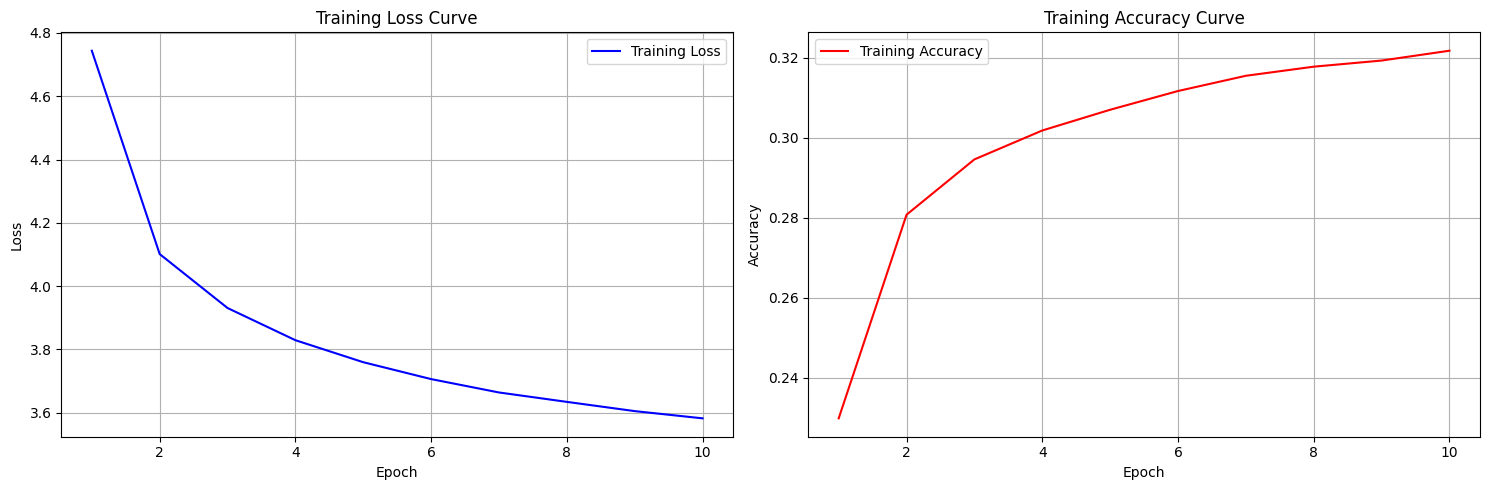

Learning curves saved to rnn_learning_curves.png


In [ ]:
# plot learning curves
trainer.plot_learning_curves('rnn_learning_curves.png')

In [ ]:
# evaluate on test data
evaluate_on_test_data(trainer, vocab, 'data/test.txt', SEQ_LENGTH, BATCH_SIZE)

Evaluating model on data/test.txt...
Loaded 649918 texts from data/test.txt
Preparing training sequences...
Created 200009 training sequences



模型測試結果
測試損失 (Test Loss): 3.9018
測試準確率 (Test Accuracy): 0.3160 (31.60%)
測試困惑度 (Test Perplexity): 49.4913


(3.9017964518616353, 0.31597578108985097, 49.49127799171478)

In [ ]:
# test incomplete sentences
test_incomplete_sentences(trainer, 'data/incomplete.txt')

Testing incomplete sentence completion...

模型文本補全結果
輸入: cover with
補全: cover with water and salt and pepper together to make a small amount of 3 cups powdered sugar and
--------------------------------------------------
輸入: roll up
補全: roll up the pastry pull off a greased 8x8 plate with cooking spray or an additional 45 minutes or
--------------------------------------------------
輸入: cook the
補全: cook the meat minute for 2 minutes until thick and bubbly and warm in a preheated oven for about
--------------------------------------------------
輸入: stir in
補全: stir in basil and stir fry to make the sald over their own berries and the curry paste and
--------------------------------------------------
輸入: spread out
補全: spread out of the mixture and stir until blended and beat well in the center of the pan on
--------------------------------------------------
輸入: transfer the
補全: transfer the ribs to the stalks over the loves cheese and add in the pan and let stand for
-------------------

## LSTM Training

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 超參數
HIDDEN_DIM = 128
NUM_LAYERS = 2
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
BATCH_SIZE = 32
SEQ_LENGTH = 3

train_texts = load_data('data/train.txt')

vocab = Vocabulary()
vocab.build_vocab(train_texts, min_freq=3)

train_dataset = TextDataset(train_texts, vocab, SEQ_LENGTH)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

model = LSTMLanguageModel(
    vocab_size=len(vocab),
    embed_dim=HIDDEN_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS
).to(device)

print(model)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

trainer = LSTMTrainer(model, vocab, device)

print("Starting training...")

epoch_pbar = tqdm(range(NUM_EPOCHS), desc="LSTM Training Progress")

for epoch in epoch_pbar:
    start_time = time.time()
    
    train_loss, train_accuracy = trainer.train_epoch(train_dataloader)
    
    epoch_time = time.time() - start_time
    
    epoch_pbar.set_postfix({
        'Loss': f'{train_loss:.4f}',
        'Acc': f'{train_accuracy:.4f}',
        'Time': f'{epoch_time:.1f}s'
    })
    
    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Time: {epoch_time:.2f}s')
    

torch.save({
    'model_state_dict': model.state_dict(),
    'vocab': vocab,
    'hyperparameters': {
        'vocab_size': len(vocab),
        'embed_dim': HIDDEN_DIM,
        'hidden_dim': HIDDEN_DIM,
        'num_layers': NUM_LAYERS
    }
}, 'lstm_model.pth')

print("Model saved to lstm_model.pth")

Using device: cuda
Loaded 2599668 texts from data/train.txt
Building vocabulary...
Vocabulary size: 15843
Most common words: [('and', 910902), ('the', 851351), ('in', 479094), ('a', 463682), ('to', 460822), ('with', 307128), ('until', 276529), ('add', 252377), ('minutes', 233439), ('of', 231635)]
Preparing training sequences...
Created 200001 training sequences
LSTMLanguageModel(
  (embedding): Embedding(15843, 128)
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=128, out_features=15843, bias=True)
)
Model parameters: 4,335,843
Starting training...


LSTM Training Progress:  10%|█         | 1/10 [00:58<08:49, 58.82s/it, Loss=5.0259, Acc=0.1962, Time=58.8s]

Epoch 1/10, Train Loss: 5.0259, Train Accuracy: 0.1962, Time: 58.82s


LSTM Training Progress:  20%|██        | 2/10 [02:01<08:11, 61.38s/it, Loss=4.2363, Acc=0.2633, Time=63.2s]

Epoch 2/10, Train Loss: 4.2363, Train Accuracy: 0.2633, Time: 63.18s


LSTM Training Progress:  30%|███       | 3/10 [03:01<07:03, 60.45s/it, Loss=3.9521, Acc=0.2891, Time=59.3s]

Epoch 3/10, Train Loss: 3.9521, Train Accuracy: 0.2891, Time: 59.34s


LSTM Training Progress:  40%|████      | 4/10 [03:59<05:56, 59.37s/it, Loss=3.7890, Acc=0.3030, Time=57.7s]

Epoch 4/10, Train Loss: 3.7890, Train Accuracy: 0.3030, Time: 57.71s


LSTM Training Progress:  50%|█████     | 5/10 [05:00<05:00, 60.05s/it, Loss=3.6799, Acc=0.3121, Time=61.3s]

Epoch 5/10, Train Loss: 3.6799, Train Accuracy: 0.3121, Time: 61.25s


LSTM Training Progress:  60%|██████    | 6/10 [06:01<04:01, 60.46s/it, Loss=3.5969, Acc=0.3192, Time=61.2s]

Epoch 6/10, Train Loss: 3.5969, Train Accuracy: 0.3192, Time: 61.25s


LSTM Training Progress:  70%|███████   | 7/10 [06:58<02:57, 59.16s/it, Loss=3.5283, Acc=0.3256, Time=56.5s]

Epoch 7/10, Train Loss: 3.5283, Train Accuracy: 0.3256, Time: 56.50s


LSTM Training Progress:  80%|████████  | 8/10 [07:59<01:59, 59.94s/it, Loss=3.4735, Acc=0.3304, Time=61.6s]

Epoch 8/10, Train Loss: 3.4735, Train Accuracy: 0.3304, Time: 61.60s


LSTM Training Progress:  90%|█████████ | 9/10 [09:03<01:01, 61.06s/it, Loss=3.4250, Acc=0.3349, Time=63.5s]

Epoch 9/10, Train Loss: 3.4250, Train Accuracy: 0.3349, Time: 63.53s


LSTM Training Progress: 100%|██████████| 10/10 [10:00<00:00, 60.07s/it, Loss=3.3829, Acc=0.3384, Time=57.5s]


Epoch 10/10, Train Loss: 3.3829, Train Accuracy: 0.3384, Time: 57.47s
Model saved to lstm_model.pth


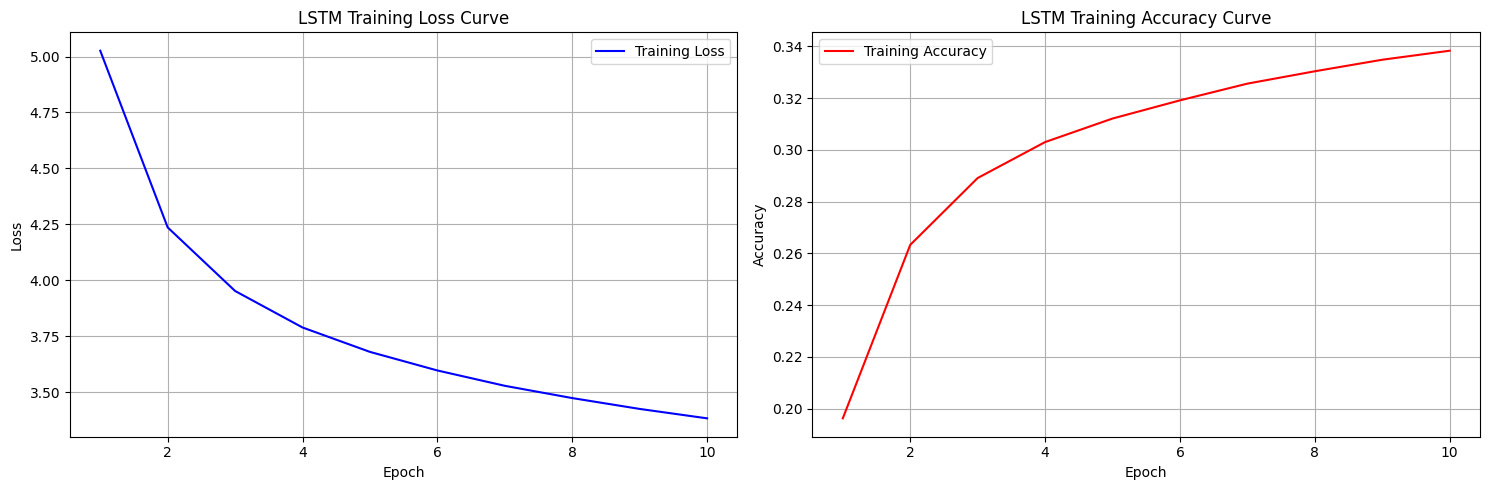

Learning curves saved to lstm_learning_curves.png


In [ ]:
trainer.plot_learning_curves('lstm_learning_curves.png')

In [ ]:
evaluate_on_test_data(trainer, vocab, 'data/test.txt', SEQ_LENGTH, BATCH_SIZE)

Evaluating model on data/test.txt...
Loaded 649918 texts from data/test.txt
Preparing training sequences...
Created 200009 training sequences



模型測試結果
測試損失 (Test Loss): 3.7758
測試準確率 (Test Accuracy): 0.3330 (33.30%)
測試困惑度 (Test Perplexity): 43.6325


(3.7758025079058894, 0.333000014999325, 43.63250970339064)

In [ ]:
test_incomplete_sentences(trainer, 'data/incomplete.txt')

Testing incomplete sentence completion...

模型文本補全結果
輸入: cover with
補全: cover with foil and leave in the refrigerator overnight for 30 minutes or until translucent and onion color and
--------------------------------------------------
輸入: roll up
補全: roll up the excess fat and add the artichokes and bake the garlic for 1 hour or until almost
--------------------------------------------------
輸入: cook the
補全: cook the potatoes according to directions over medium high heat until the onion is dissolved and the desired thickness
--------------------------------------------------
輸入: stir in
補全: stir in the milk and heat through until rice is bubbly and bubbly and the topping is light and
--------------------------------------------------
輸入: spread out
補全: spread out the base of the prepared pan baking dish and allow to marinate up to cool before serving
--------------------------------------------------
輸入: transfer the
補全: transfer the beef to a shallow saucepan and stir in the cream and 

### Question: Analyze and compare the differences among the n-gram model, the RNN model, and the LSTM model, including the hardware resources required for their operations, the computation time taken for training, and the results of perplexity and accuracy.
Ans: The n-gram, RNN, and LSTM models differ significantly in how they model language dependencies, as well as in their computational requirements and performance.

1. Model Characteristics
    *   N-gram Model: 
        The n-gram model relies on fixed-length context windows, assuming that the next word depends only on the previous n-1 words. It is simple and efficient but suffers from data sparsity and cannot capture long-term dependencies.
    * 	RNN Model:
        The Recurrent Neural Network introduces recurrence, allowing information from previous time steps to influence future predictions. It can theoretically model longer sequences than n-grams, but in practice, it struggles with vanishing or exploding gradients, which limits its ability to remember long contexts.
	* 	LSTM Model:
        The Long Short-Term Memory (LSTM) improves upon RNNs by introducing gating mechanisms (input, forget, and output gates) that help preserve information over long sequences. This enables it to effectively capture both short- and long-term dependencies.

2. Hardware Resources
	*	N-gram: Requires minimal hardware resources (CPU-friendly) and memory only for storing word counts and probability tables.
	*	RNN: Needs more memory and GPU support for efficient matrix operations, as it involves backpropagation through time (BPTT).
	*	LSTM: Demands the most computational resources among the three due to additional gate parameters and more complex gradient updates. It typically benefits greatly from GPU acceleration.

3. Computation Time
	*	N-gram: Fast to train since it only involves counting occurrences.
	*	RNN: Training is slower because gradients must be propagated through multiple time steps.
	*	LSTM: Even slower than RNN due to the extra gate computations, but usually converges in fewer epochs because of its stability.

4. Perplexity and Accuracy
	*	The accuracy ceiling of the N-gram model is relatively lower compared to RNN and LSTM. Since the training time for RNN and LSTM is much longer than for the N-gram model, I used a smaller training dataset for them. Under the condition where the sequence length is set to three, the accuracy of both RNN and LSTM nearly matches that of the N-gram model. Moreover, as shown in the figure, neither model has reached overfitting yet, indicating that both RNN and LSTM have the potential to achieve even higher accuracy with more training.
	*	In terms of perplexity, the LSTM model achieves a lower value than the RNN model, suggesting that LSTM is more confident and consistent in its sequence generation.